In [53]:
import torch
from torchvision.utils import make_grid, save_image
from PIL import Image
import torchvision
from torchvision import transforms
from glob import glob
import cv2
from torch.utils.data import Dataset, DataLoader
from torch import nn, optim
import numpy as np
import torchvision.utils as vutils

# from torch_snippets import *


In [47]:
#torch.cuda.empty_cache

device= torch.device("cuda" if torch.cuda.is_available else 'cpu')
device

device(type='cuda')

In [54]:
import zipfile
import os

# Define your ZIP file name
zip_file = "archive.zip"  # Change this to your actual ZIP file name

# Extract it to a folder with the same name
extract_folder = zip_file.replace(".zip", "")  
# os.makedirs(extract_folder, exist_ok=True)

# # Extract files
# with zipfile.ZipFile(zip_file, "r") as zip_ref:
    # zip_ref.extractall(extract_folder)

print(f"Extracted to: {extract_folder}")


Extracted to: archive


In [55]:
#opencv pretreained model that extracts faces
face_cascade=cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_detault.xml')
print(cv2.data.haarcascades)


c:\I\gans-class-example\env\lib\site-packages\cv2\data\


In [ ]:
import cv2
import os
import numpy as np
from tqdm import tqdm
from PIL import Image

# this must happen as a preprocess step because it runs on cpu
# Paths to datasets
female_path='archive/Male and Female face dataset/Female Faces'
male_path='archive/Male and Female face dataset/Male Faces'
female_images= glob(f'{female_path}/*.jpg') + glob(f'{female_path}/*.png') +glob(f'{female_path}/*.jpeg') 
male_images=glob(f'{male_path}/*.jpg') +glob(f'{male_path}/*.jpeg')+glob(f'{male_path}/*.png')

output_dir = "preprocessed_faces"

# Create output directories
os.makedirs(os.path.join(output_dir, "Male"), exist_ok=True)
os.makedirs(os.path.join(output_dir, "Female"), exist_ok=True)

# Load face detector
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')

def process_images(image_paths, output_subdir):
    for img_path in tqdm(image_paths, desc=f"Processing {output_subdir}"):
        img = cv2.imread(img_path)
        img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        
        faces = face_cascade.detectMultiScale(img_gray, scaleFactor=1.1, minNeighbors=5)
        
        if len(faces) > 0:
            x, y, w, h = faces[0]
            face_img = img[y:y+h, x:x+w]  # Crop face
        else:
            face_img = img  # Use full image if no face found
        
        face_img = cv2.cvtColor(face_img, cv2.COLOR_BGR2RGB)  # Convert to RGB
        face_img = Image.fromarray(face_img)  # Convert to PIL Image
        
        # Save processed image
        filename = os.path.basename(img_path)
        face_img.save(os.path.join(output_dir, output_subdir, filename))

# Process both male and female datasets
process_images(male_images, "Male")
process_images(female_images, "Female")

print("Preprocessing complete! Faces saved in:", output_dir)


In [70]:
class FaceDataset(Dataset):
    def __init__(self, male_image_paths, female_image_paths):
        self.image_paths=sorted(male_image_paths) + sorted(female_image_paths)
        # self.face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')
        self.transform= transforms.Compose([
            transforms.Resize(64),
            transforms.CenterCrop(64),
            transforms.ToTensor(),
            transforms.Normalize((0.5,0.5,0.5), (0.5,0.5,0.5))
        ])
    def __len__(self):
        return len(self.image_paths)
    
    def __getitem__(self, idx):
        img_path=self.image_paths[idx]
        # img= cv2.imread(img_path)
        # img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        # faces = self.face_cascade.detectMultiScale(img_gray, scaleFactor=1.1, minNeighbors=5).to(device)
        # if len(faces) == 0:
        #     face_img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # use the full image
        #     face_img = Image.fromarray(face_img)
        # else:
        #     x, y, w, h = faces[0]
        #     face_img = img[y:y+h, x:x+w]
        #     face_img = cv2.cvtColor(face_img, cv2.COLOR_BGR2RGB)
        #     face_img = Image.fromarray(face_img)
            
        face_img= Image.open(img_path)
        gender= np.where('Female'  in str(img_path),1,0)
        return self.transform(face_img), torch.tensor(gender).long() 
      

In [71]:
output_dir = "preprocessed_faces"
male_path=os.path.join(output_dir, "Male")
print(male_path)
female_path=os.path.join(output_dir, "Female")
female_images= glob(f'{female_path}/*.jpg') + glob(f'{female_path}/*.png') +glob(f'{female_path}/*.jpeg') 
male_images=glob(f'{male_path}/*.jpg') +glob(f'{male_path}/*.jpeg')+glob(f'{male_path}/*.png')

dataset= FaceDataset(male_images, female_images)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

preprocessed_faces\Male


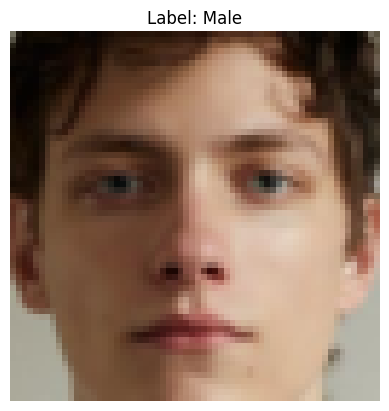

In [72]:
import matplotlib.pyplot as plt

# Get one batch
images, labels = next(iter(dataloader))

# Take the first image in the batch
img = images[0]
label = labels[0].item()

# Convert from tensor (C, H, W) to (H, W, C) and denormalize
img = img.permute(1, 2, 0) * 0.5 + 0.5  # scale back to [0,1]

plt.imshow(img.numpy())
plt.title(f'Label: {"Female" if label == 1 else "Male"}')
plt.axis('off')
plt.show()


In [73]:
#initialize weights to make the model more stable
def weights_init(m):
    classname=m.__class__.__name__
    if classname.find('Conv') !=-1 :
        nn.init.normal_(m.weight.data, 0.0,0.02).to(device)
    elif classname.find('BatchNorm')!=-1:
        nn.init.normal_(m.weight.data,1.0,0.02).to(device)
        nn.init.constant_(m.bias.data,0).to(device)

In [74]:
class Discriminator(nn.Module):
    def __init__(self, embedding_size=32):
        super(Discriminator, self).__init__()
        self.embedding_size= embedding_size
        self.label_embeddings=nn.Embedding(2,self.embedding_size).to(device)
        self.model=nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=4, stride=2, padding=1, bias=False),
            nn.LeakyReLU(0.2,inplace=True),
            nn.Conv2d(64, 64*2, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(64*2),
            nn.LeakyReLU(0.2,inplace=True),
            nn.Conv2d(64*2, 64*4, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(64*4),
            nn.LeakyReLU(0.2,inplace=True),
            nn.Conv2d(64*4, 64*8, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(64*8),
            nn.LeakyReLU(0.2,inplace=True),
            nn.Conv2d(64*8, 64, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2,inplace=True),
            nn.Flatten()
        ).to(device=device)
        
        self.model2 = nn.Sequential(
            nn.Linear(288,100),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(100,1),
            nn.Sigmoid()
        ).to(device)
        
        self.apply(weights_init)
    def forward(self, input, labels):
        # print(f'discriminator input: {input.shape}')
        x=self.model(input).to(device)
        # print(f'featuremap:{x.shape}')
        y=self.label_embeddings(labels)
        # print(f'embedding: {y.shape}')
        input=torch.cat([x,y],1).to(device)
        # print(f'concated: {input.shape}')
        final_output=self.model2(input).to(device)
        # print(f'output: {final_output}')
        return final_output

In [59]:
# from torchsummery import summery
# discriminator = Discriminator().to(device)
# summery(discriminator, torch.zeros(32,2,64,64), torch.zeros(32).long().to(device))

In [75]:
class Generator(nn.Module):
    def __init__(self, embedding_size=32):
        super(Generator, self).__init__()
        self.embedding_size= embedding_size
        self.label_embeddings = nn.Embedding(2, self.embedding_size).to(device)
        self.model = nn.Sequential(
            nn.ConvTranspose2d(100 + self.embedding_size, 64*8, kernel_size=4,stride=1, padding=0, bias=False),
            nn.BatchNorm2d(64*8),
            nn.ReLU(True),
            nn.ConvTranspose2d(64*8, 64*4, kernel_size=4,stride=2, padding=1, bias=False),
            nn.BatchNorm2d(64*4),
            nn.ReLU(True),
            nn.ConvTranspose2d(64*4, 64*2, kernel_size=4,stride=2, padding=1, bias=False),
            nn.BatchNorm2d(64*2),
            nn.ReLU(True),
            nn.ConvTranspose2d(64*2, 64, kernel_size=4,stride=2, padding=1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(True),
            nn.ConvTranspose2d(64, 3, kernel_size=4,stride=2, padding=1, bias=False),
            nn.Tanh()
        ).to(device)
        self.apply(weights_init)
    def forward(self, input_noise, labels):
        label_embeddings = self.label_embeddings(labels).view(len(labels), self.embedding_size,1,1).to(device)
        input= torch.cat([input_noise, label_embeddings],1).to(device)
        return self.model(input).to(device)

In [61]:
# generator = Generator().to(device)
# summery(generator, torch.zeros(32,100,1,1).to(device),torch.zeros(32).long().to(device))

In [63]:
def denormalize(input_image_tensors):
  mean=0.5
  std=0.5
  input_image_tensors = (input_image_tensors * mean) + std
  return input_image_tensors

In [ ]:
batch_size=64
def show_generated_samples(sample_imgs):
    grid = vutils.make_grid(denormalize(sample_imgs[:batch_size].cpu()), normalize=True)
    plt.figure(figsize=(8, 8))
    plt.axis("off")
    plt.imshow(grid.permute(1, 2, 0))  # Convert from (C, H, W) to (H, W, C)
    plt.show()

def save_generated_samples(epoch, sample_imgs):
    os.makedirs("generated_images", exist_ok=True)
    fname= os.path.join("generated_images", f"img-{epoch}.jpg")
    save_image(sample_imgs[:batch_size], fname , normalize=True)

class FaceGAN:
  def __init__(self, latent_size , lr, batch_size, betas =(0.5, 0.999), device=device): #betas default for Adam
    self.device = device
    self.latent_size = latent_size
    self.batch_size = batch_size

    self.generator = Generator().to(device)
    self.discriminator = Discriminator().to(device)

    #two independent network, two optimizer
    self.opt_g = optim.Adam(self.generator.parameters(), lr=lr, betas = betas)
    self.opt_d = optim.Adam(self.discriminator.parameters(), lr=lr, betas = betas)

    self.criterian = nn.BCELoss()

    #initial random latent variable
    self.validation_noise= torch.randn(self.batch_size, latent_size,1,1,device=device)
    self.validation_labels= torch.LongTensor(np.random.randint(0,2,len(self.validation_noise))).to(device)

    self.all_food_images=[]
    self.g_losses =[]
    self.d_losses = []

  def train_epoch(self, dataloader):
    self.generator.train()
    self.discriminator.train()
    for real_images, real_labels in dataloader: 
      real_images = real_images.to(device)
      real_labels= real_labels.to(device)
      
      batch_size = len(real_images)

      self.opt_g.zero_grad()

      fake_labels= torch.LongTensor(np.random.randint(0,2,len(real_images))).to(device)
      noise = torch.randn(batch_size, self.latent_size,1,1,device=device)
      fake_images= self.generator(noise, fake_labels)
      # print(f'fake image from generator {fake_images.shape}')
      preds = self.discriminator(fake_images, fake_labels)  #fake 0 or real 1
      g_loss = self.adversarial_loss(preds, torch.ones(batch_size, 1 , device= self.device), device=self.device)  #if pred is 1 then generator saying the image is real, and the loss will be 0
      g_loss.backward()
      self.opt_g.step()

      self.opt_d.zero_grad()

      real_image_label = self.discriminator(real_images, real_labels)
      real_image_label_loss= self.adversarial_loss(real_image_label, torch.ones(batch_size,1, device= self.device), device=self.device)
      fake_image_label = self.discriminator(fake_images.detach(), fake_labels)
      fake_image_label_loss= self.adversarial_loss(fake_image_label, torch.zeros(batch_size, 1 , device= self.device), device=self.device)

      d_loss= fake_image_label_loss + real_image_label_loss
      d_loss.backward()
      self.opt_d.step()

      self.g_losses.append(g_loss.item())
      self.d_losses.append(d_loss.item())

  def adversarial_loss(self, preds, targets, device):
      return self.criterian(preds, targets)

  def generate_samples(self, epoch):
      self.generator.eval()
      with torch.no_grad():
        sample_imgs = self.generator(self.validation_noise, self.validation_labels)
        self.all_food_images.append(sample_imgs.cpu())
        save_generated_samples(epoch, sample_imgs)
        show_generated_samples(sample_imgs)


In [ ]:
latent_size= 100
num_epochs=100

model = FaceGAN(latent_size = latent_size, lr= 0.0002,batch_size=32,
                betas =(0.5, 0.999), device=device)
for epoch in range(num_epochs):
  model.train_epoch(dataloader)
  model.generate_samples(epoch)

  avg_g_loss= sum(model.g_losses[-len(dataloader):])/len(dataloader)
  avg_d_loss = sum(model.d_losses[-len(dataloader):])/len(dataloader)
  print(f"epoch {epoch+1}/{num_epochs} | G Loss {avg_g_loss:.4f} | D Loss {avg_d_loss:.4f}")


epoch 1:

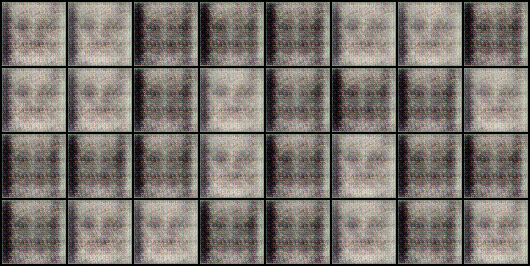

epoch 41:

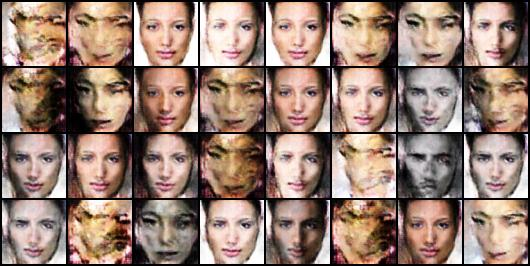

epoch 85:

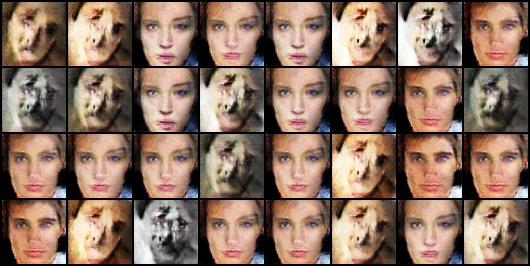


Other images can be found in generated_images folder.